In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

from sklearn.feature_selection import RFE
from operator import itemgetter        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1-bin.csv
/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
The data has been collected by hand as it was formatted differently for nearly every row. Some points have been imputed by hand elsewhere, based off of photos, educated guesses and industry knowledge. Enough data has been collected so that feature engineering is now underway. One major point is how to encompass the information about number of doors and windows, experimenting with different ways of tackling these columns is currently underway. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1-bin.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,A/C,Roof Rack,Driver Side Window,...,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,2,2,2,...,0,2,1,2,2,1,2,2,2,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,2,2,2,...,0,2,1,2,2,1,2,2,2,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,2,2,2,...,0,2,1,2,2,1,2,2,2,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,2,2,2,...,0,2,1,2,2,1,2,2,2,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,2,2,2,...,0,2,1,2,2,0,2,2,2,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                      object
model                             object
total dry weight                   int64
length                           float64
Cabin exterior width             float64
exterior height                  float64
interior height highest point    float64
A/C                                int64
Roof Rack                          int64
Driver Side Window                 int64
Driver Side Door                   int64
Driver Side Door Window            int64
Passenger Side Door                int64
Passenger Side Door Window         int64
Passenger Side Window              int64
Rear Door Window                   int64
Usage Intent- On or Off Road      object
Rear Door                         object
Wall Material                      int64
Spare Tire                         int64
Battery Power Supply               int64
Cabinets                           int64
Refrigerator                       int64
Awning                             int64
Solar           

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                      0
model                            20
total dry weight                  0
length                            0
Cabin exterior width              0
exterior height                   0
interior height highest point     0
A/C                               0
Roof Rack                         0
Driver Side Window                0
Driver Side Door                  0
Driver Side Door Window           0
Passenger Side Door               0
Passenger Side Door Window        0
Passenger Side Window             0
Rear Door Window                  0
Usage Intent- On or Off Road      0
Rear Door                         0
Wall Material                     0
Spare Tire                        0
Battery Power Supply              0
Cabinets                          0
Refrigerator                      0
Awning                            0
Solar                             0
STOVE                             0
USB Charging                      0
Base price                  

There are no missing values because the data has been imputed by hand beforehand. 

In [5]:
data.shape

(110, 28)

In [6]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"Usage Intent- On or 2": "Usage Intent- On or Off Road", "exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [7]:
#checking the categories are clean
data['Passenger Side Door Window'].value_counts()

2    85
1    19
0     6
Name: Passenger Side Door Window, dtype: int64

In [8]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

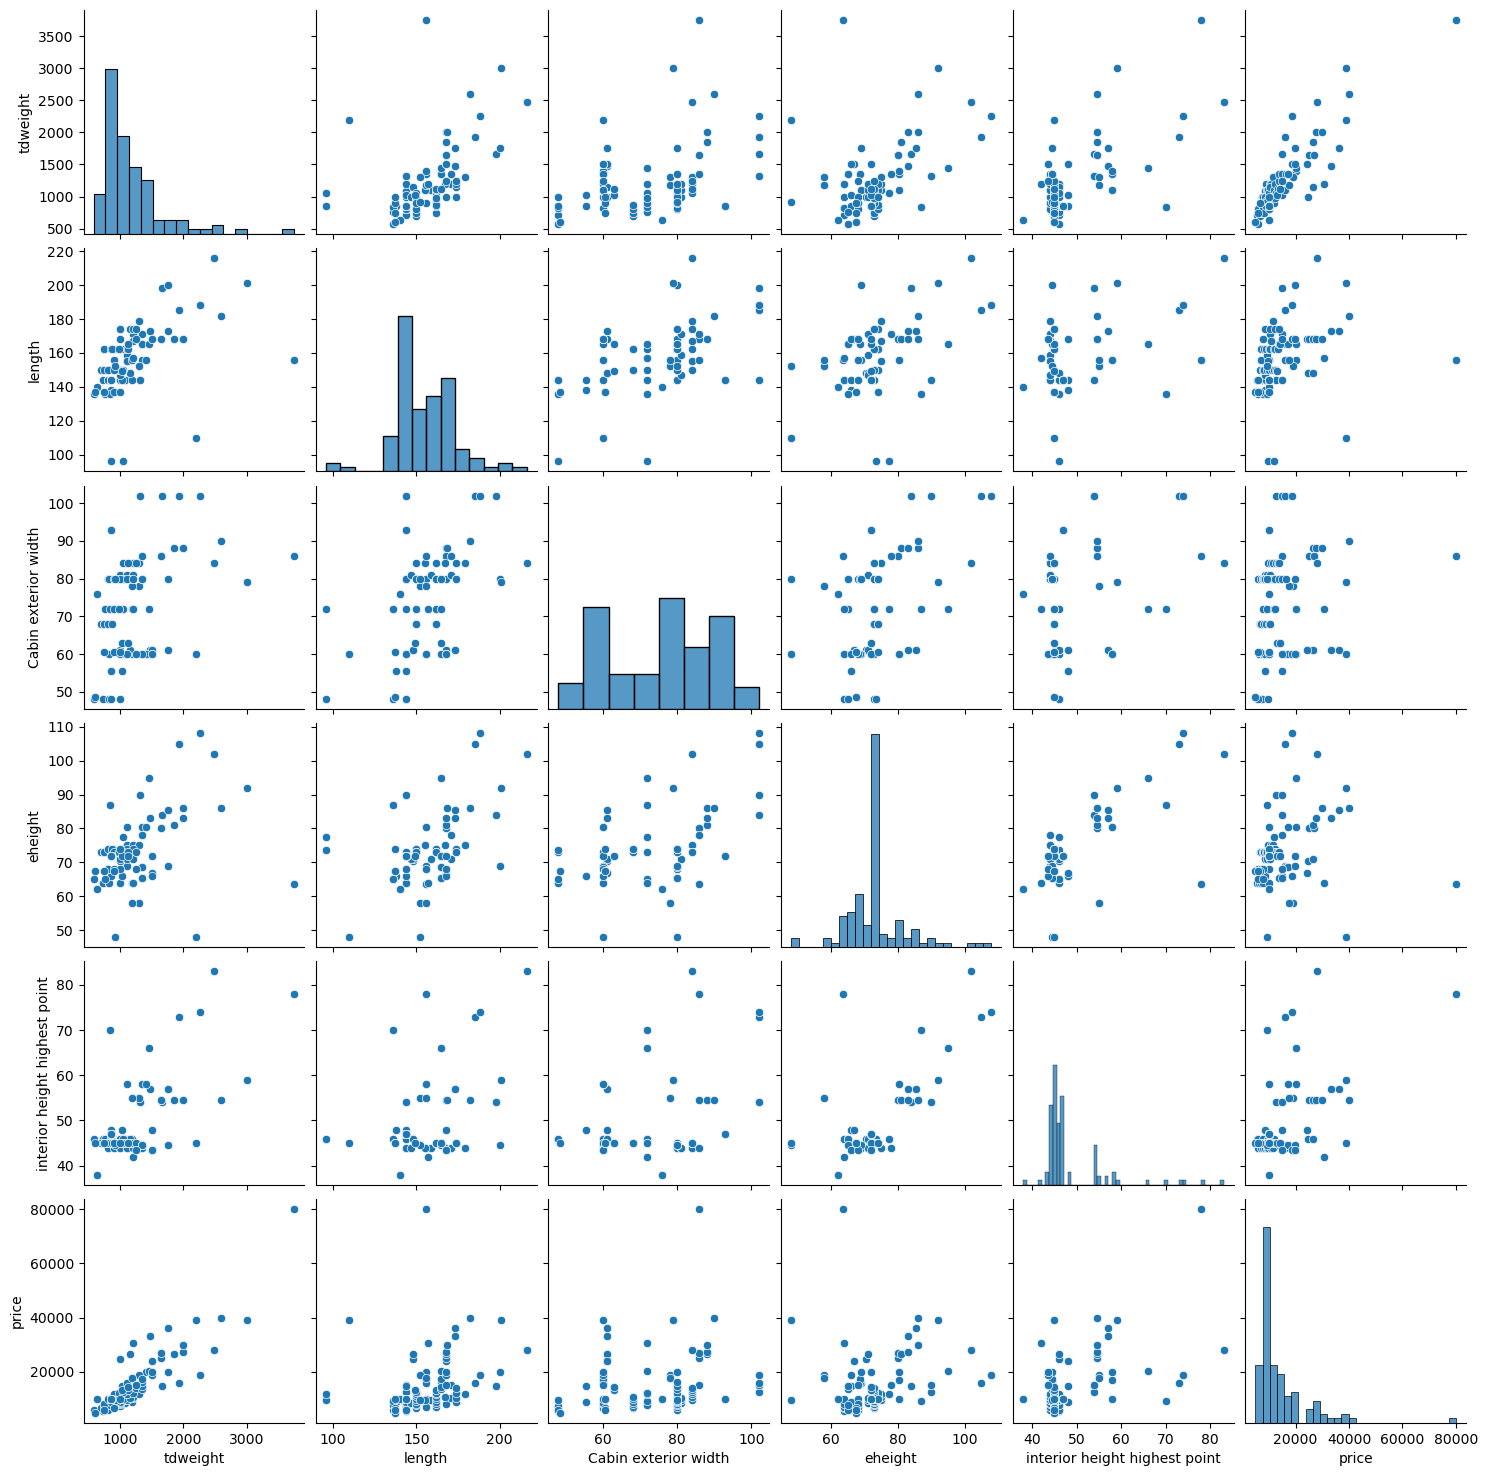

In [9]:
sns.pairplot(data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'price']])

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

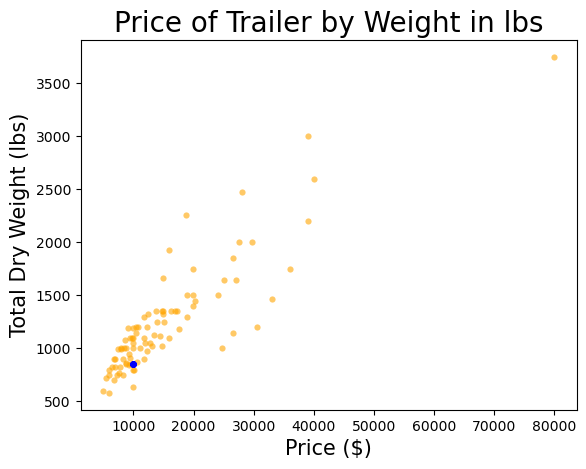

In [10]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

In [11]:
#drop the very expensive heavy trailer outlier
data=data.drop(data.index[75])

Now let's look at how a few features map onto the weight vs. price

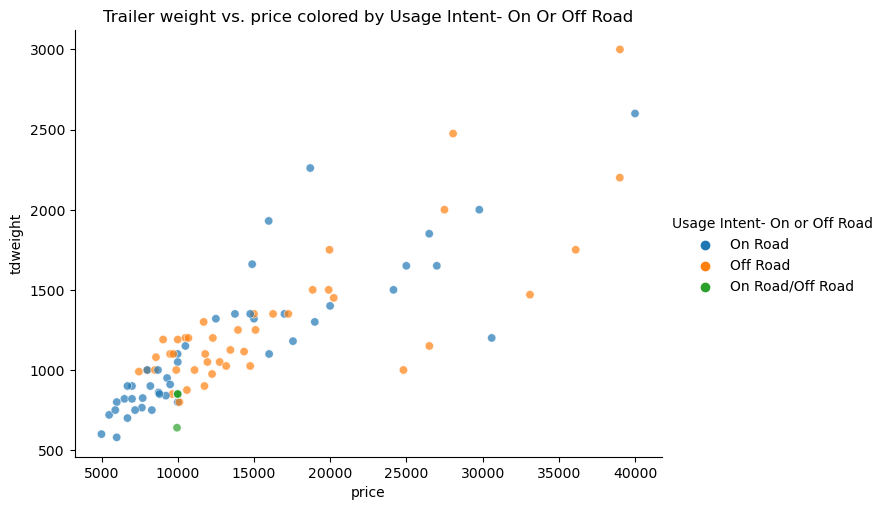

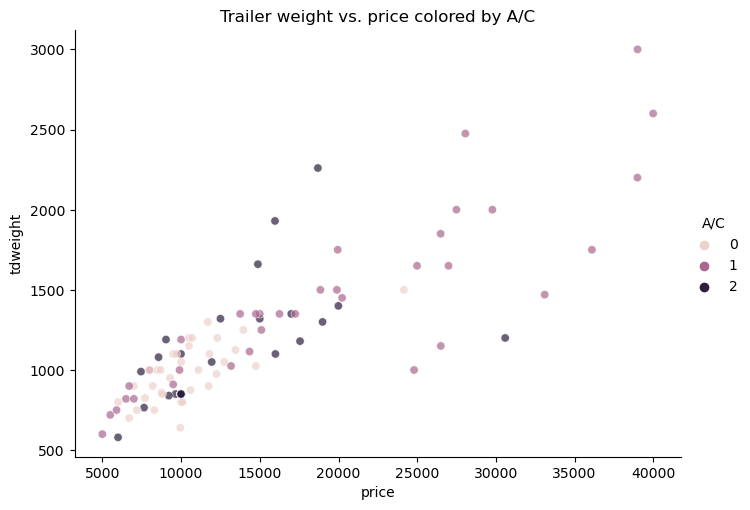

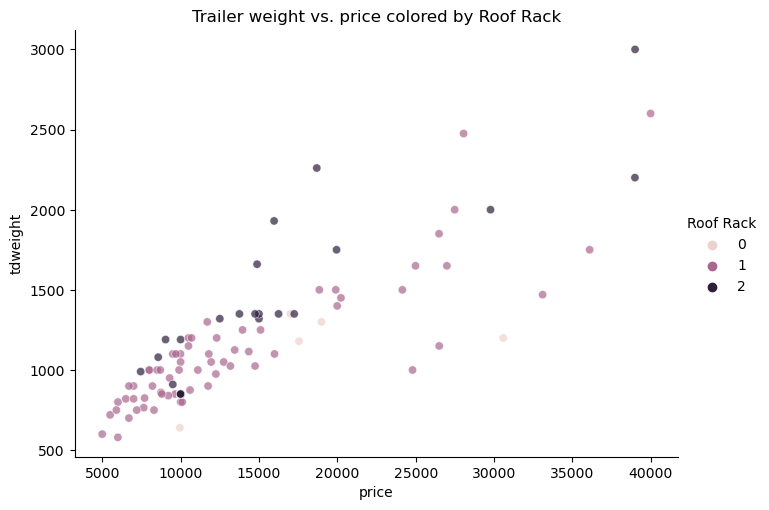

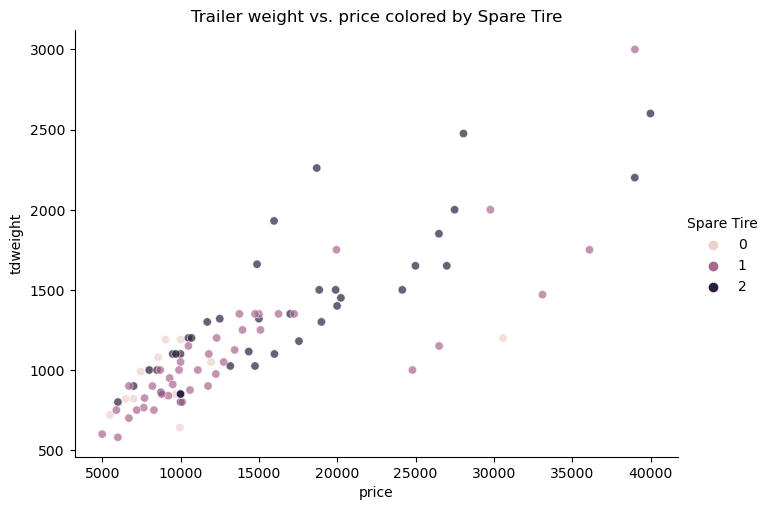

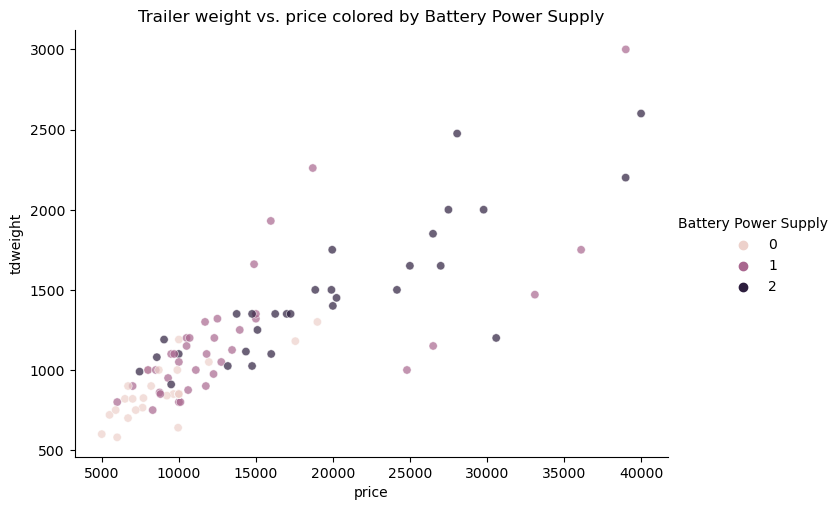

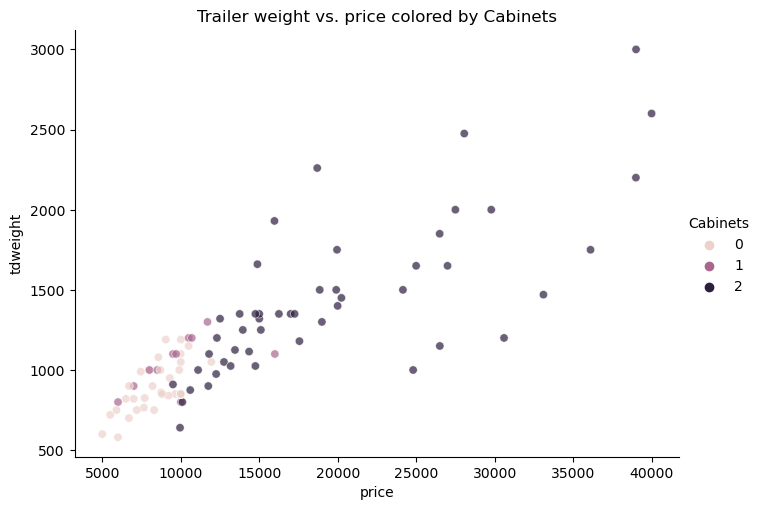

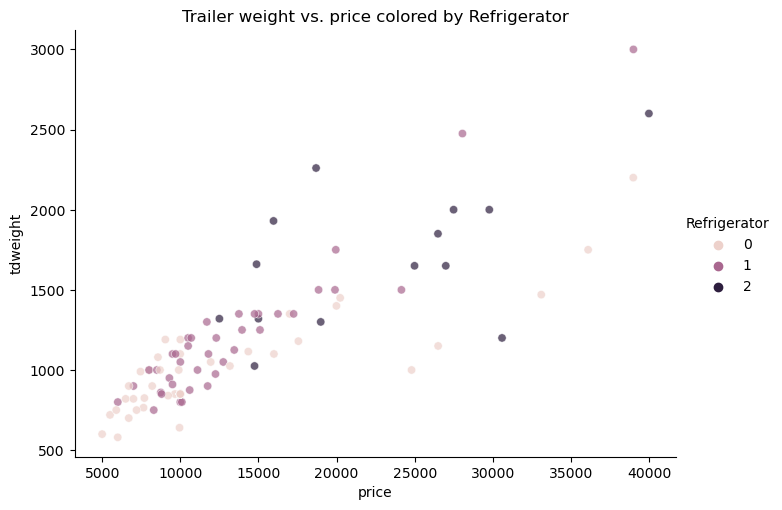

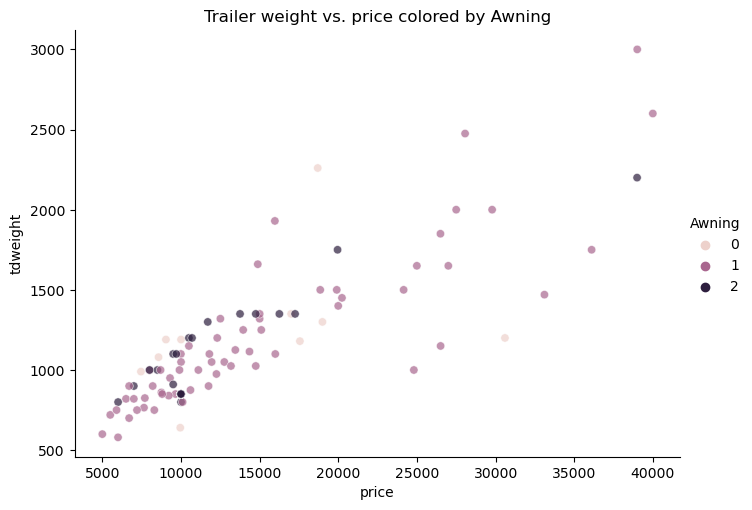

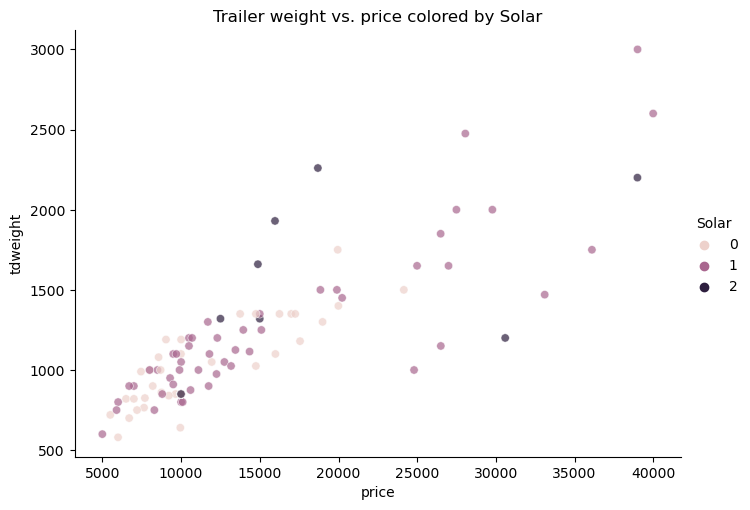

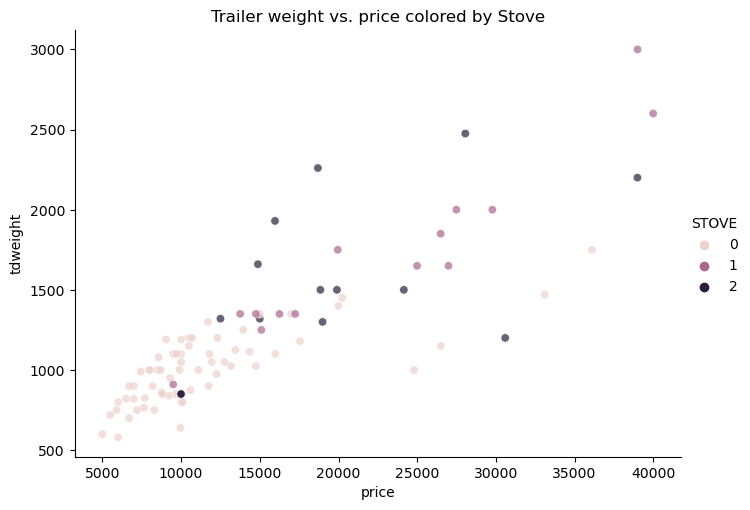

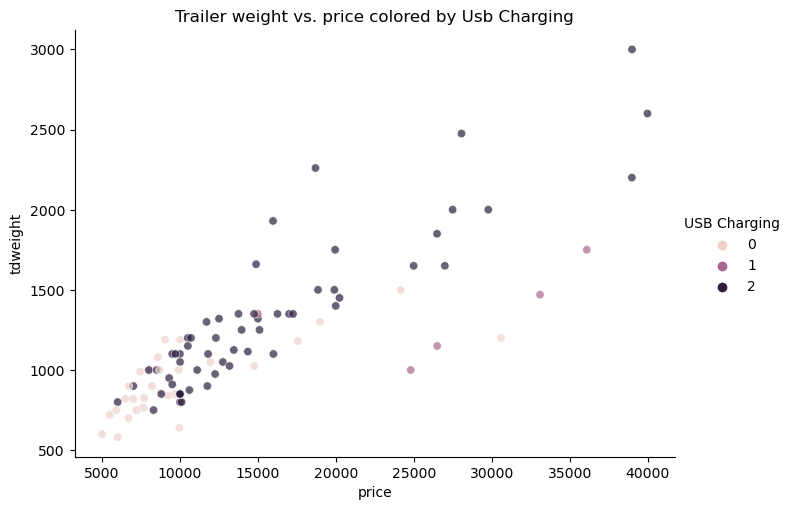

In [12]:
for c in ['Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.7)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [13]:
#These features are highly negatively correlated and contain rather repetitive data
#Relevant columns are added together to reduce complexity
#No:0, Option:1, Yes:2
data["Windows"] = data["Driver Side Window"] + data["Passenger Side Window"]
data["Doors"] = data["Driver Side Door"] + data["Passenger Side Door"]
data["Door Windows"] = data["Driver Side Door Window"] + data["Passenger Side Door Window"]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 109
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Manufacturer                   109 non-null    object 
 1   model                          89 non-null     object 
 2   tdweight                       109 non-null    int64  
 3   length                         109 non-null    float64
 4   Cabin exterior width           109 non-null    float64
 5   eheight                        109 non-null    float64
 6   interior height highest point  109 non-null    float64
 7   A/C                            109 non-null    int64  
 8   Roof Rack                      109 non-null    int64  
 9   Driver Side Window             109 non-null    int64  
 10  Driver Side Door               109 non-null    int64  
 11  Driver Side Door Window        109 non-null    int64  
 12  Passenger Side Door            109 non-null    int

In [15]:
#reorder the columns so there are no problems with slicing/encoding
data = data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Rear Door Window', 'Rear Door', 'Wall Material', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'price']]

In [16]:
#checking the columns are reordered
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 109
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tdweight                       109 non-null    int64  
 1   length                         109 non-null    float64
 2   Cabin exterior width           109 non-null    float64
 3   eheight                        109 non-null    float64
 4   interior height highest point  109 non-null    float64
 5   Windows                        109 non-null    int64  
 6   Doors                          109 non-null    int64  
 7   Door Windows                   109 non-null    int64  
 8   Rear Door Window               109 non-null    int64  
 9   Rear Door                      109 non-null    object 
 10  Wall Material                  109 non-null    int64  
 11  Usage Intent- On or Off Road   109 non-null    object 
 12  A/C                            109 non-null    int

In [17]:
#select the categorical data for encoding
#cat_data = data.iloc[:, 13:16]
#cat_data

In [18]:
cat_data = data[['Rear Door', 'Usage Intent- On or Off Road']]
cat_data

,Rear Door,Usage Intent- On or Off Road
0,GALLEY,On Road
1,GALLEY,On Road
2,GALLEY,On Road
3,GALLEY,On Road
4,No,On Road
...,...,...
105,Yes,On Road/Off Road
106,Yes,On Road/Off Road
107,Yes,On Road/Off Road
108,Yes,On Road/Off Road


In [19]:
#doesn't help
#created dummy variables from categories (also can use OneHotEncoder)
#all_dummies = pd.get_dummies(data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'USB Cost', 'price']])

In [20]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 109
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tdweight                       109 non-null    int64  
 1   length                         109 non-null    float64
 2   Cabin exterior width           109 non-null    float64
 3   eheight                        109 non-null    float64
 4   interior height highest point  109 non-null    float64
 5   Windows                        109 non-null    int64  
 6   Doors                          109 non-null    int64  
 7   Door Windows                   109 non-null    int64  
 8   Rear Door Window               109 non-null    int64  
 9   Rear Door                      109 non-null    int64  
 10  Wall Material                  109 non-null    int64  
 11  Usage Intent- On or Off Road   109 non-null    int64  
 12  A/C                            109 non-null    int

In [21]:
#dropping columns which aren't useful 
data = data.drop(['interior height highest point'], axis=1)

In [22]:
#make a copy of the data for later
data2=data

In [23]:
data2=data2.drop(data.index[90:])

In [24]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
tdweight,1.000000,0.605198,0.399971,0.540138,0.016015,-0.025928,0.087554,-0.084811,-0.120920,0.240499,...,0.327109,0.376682,0.511941,0.558236,0.471344,0.007954,0.368965,0.640209,0.428410,0.832351
length,0.605198,1.000000,0.472049,0.472292,-0.036508,0.060798,0.289455,-0.072384,-0.436750,-0.116525,...,0.149021,0.367201,0.394320,0.467767,0.456785,0.107870,0.278529,0.359576,0.499898,0.397530
Cabin exterior width,0.399971,0.472049,1.000000,0.466580,0.123399,-0.116091,0.051627,0.157881,-0.197845,-0.064823,...,0.259431,0.354718,0.093658,0.357189,0.653500,0.146381,0.483786,0.370867,0.472746,0.157548
eheight,0.540138,0.472292,0.466580,1.000000,0.274505,-0.237849,-0.145769,-0.015949,-0.178618,-0.054674,...,0.213997,0.275343,0.158402,0.214292,0.320330,-0.168058,0.377906,0.243323,0.318951,0.314120
Windows,0.016015,-0.036508,0.123399,0.274505,1.000000,-0.361502,-0.365353,0.077495,0.198767,0.183717,...,-0.158737,0.085808,-0.101228,-0.058702,0.171874,-0.323787,0.080982,-0.131199,0.074022,-0.165411
Doors,-0.025928,0.060798,-0.116091,-0.237849,-0.361502,1.000000,0.648571,-0.186666,-0.383713,-0.084581,...,-0.004622,-0.329640,0.183848,0.033251,0.048088,0.088472,-0.089443,-0.070288,-0.019025,0.122581
Door Windows,0.087554,0.289455,0.051627,-0.145769,-0.365353,0.648571,1.000000,-0.086548,-0.557394,-0.305700,...,-0.038881,-0.020596,0.273316,0.322302,0.239779,0.077232,0.147906,0.116077,0.215707,0.266848
Rear Door Window,-0.084811,-0.072384,0.157881,-0.015949,0.077495,-0.186666,-0.086548,1.000000,0.464165,0.260598,...,0.176666,-0.192270,-0.149644,-0.140641,-0.111446,-0.204174,-0.122723,-0.062632,-0.145439,-0.059333
Rear Door,-0.120920,-0.436750,-0.197845,-0.178618,0.198767,-0.383713,-0.557394,0.464165,1.000000,0.442065,...,-0.066623,-0.352035,-0.363081,-0.281110,-0.348707,-0.325921,-0.369640,-0.057070,-0.410806,-0.068498
Wall Material,0.240499,-0.116525,-0.064823,-0.054674,0.183717,-0.084581,-0.305700,0.260598,0.442065,1.000000,...,-0.061848,-0.231568,-0.007764,-0.028514,-0.084801,-0.478850,-0.203310,0.121895,-0.325143,0.280721


<AxesSubplot:>

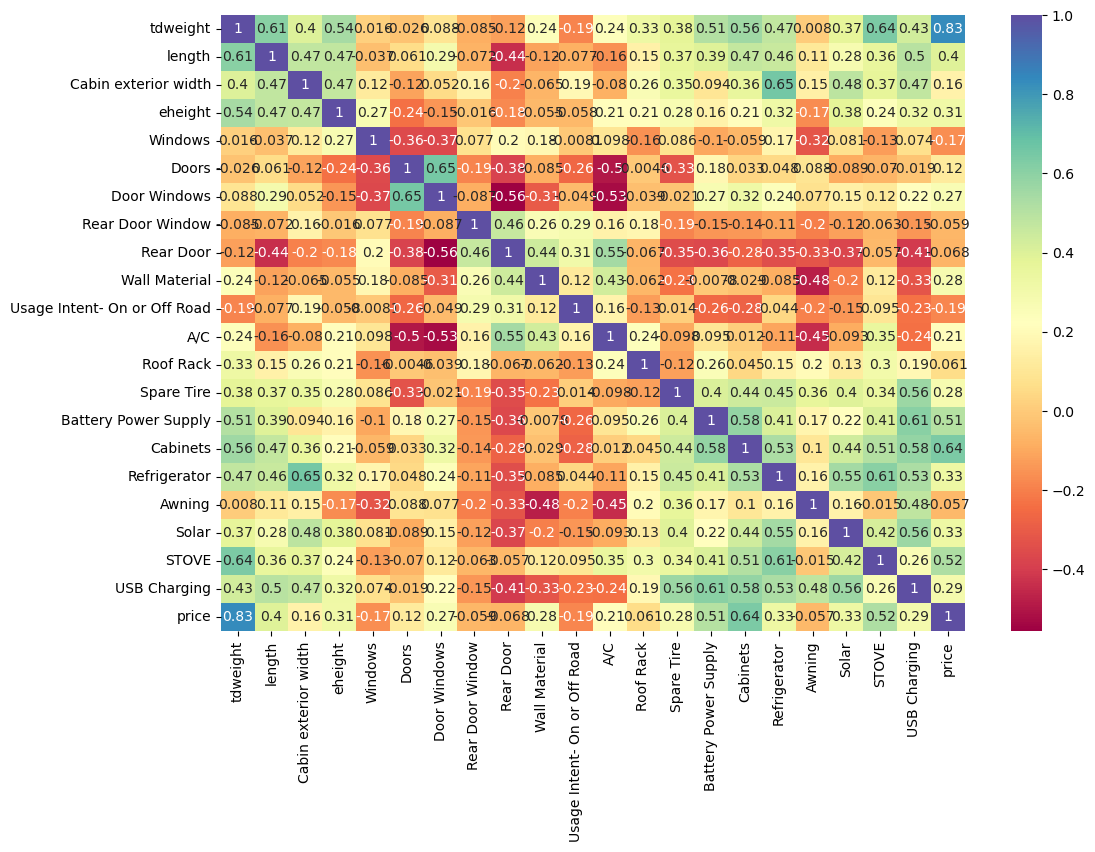

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(corr,annot=True,cmap="Spectral")

The concept of correlation measures the degree of association between features or the target variable. It can either be positive, which means an increase in the value of one feature results in an increase in the target variable, or negative, where an increase in the value of one feature results in a decrease in the target variable.

By plotting a heatmap of correlated features using the Seaborn library, it becomes easier to determine which features are strongly related to the target variable.

Here we can see that the weight has by far the largest correlation with price, however some luxury features like battery power supply, cabinets and stove also have a high correlation with price. 

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [26]:
data2

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
0,1660,198.0,102.0,84.0,4,2,2,0,0,0,...,2,2,1,2,2,1,2,2,2,14879
1,1320,144.0,102.0,90.0,4,2,2,0,0,0,...,2,2,1,2,2,1,2,2,2,12500
2,1320,144.0,102.0,90.0,4,2,2,0,0,0,...,2,2,1,2,2,1,2,2,2,14997
3,1930,185.0,102.0,105.0,4,2,2,0,0,0,...,2,2,1,2,2,1,2,2,2,15965
4,2260,188.0,102.0,108.0,4,2,2,0,1,0,...,2,2,1,2,2,0,2,2,2,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,600,137.0,48.5,67.5,3,3,3,0,0,0,...,1,1,0,0,0,1,1,0,0,4995
87,900,137.0,60.5,67.5,3,3,3,0,0,0,...,1,1,0,0,0,1,1,0,0,6700
88,750,137.0,60.5,67.5,3,3,3,0,0,0,...,1,1,0,0,0,1,1,0,0,5900
89,1000,137.0,60.5,74.0,3,3,3,0,0,0,...,1,1,0,0,0,1,1,0,0,9900


In [27]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict

X = data2.drop(['price'],axis=1)
y=data2['price']

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [29]:
#scaling the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    #EVALUATION OF THE MODEL
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    # Plotting y_test and y_pred 
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output common regression metrics: 



*Mean Absolute Error (MAE)* is the mean of the absolute value of the errors

*Mean Squared Error (MSE)* is the mean of the squared errors

*Root Mean Squared Error (RMSE)* is the square root of the mean of the squared errors

**The metrics compared:**

In comparing different metrics, the MAE represents the average error and is the most straightforward to comprehend. Meanwhile, the MSE is more commonly used than MAE as it penalizes larger errors, making it more relevant in real-world scenarios. The RMSE, on the other hand, is more widely used than MSE since it can be interpreted in the same units as the "y" variable. All of these are considered loss functions, as the objective is to minimize their values.

R^2 :  0.6527308051698422
MAE : 3054.9875851102956
MSE : 19146952.87347665
RMSE: 4375.7231257789435


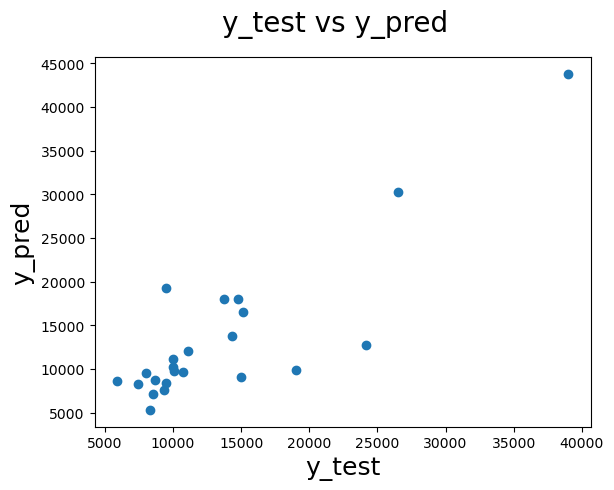

In [31]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.5368475259858327
MAE : 2954.1739130434785
MSE : 25536266.173913043
RMSE: 5053.3420796452165


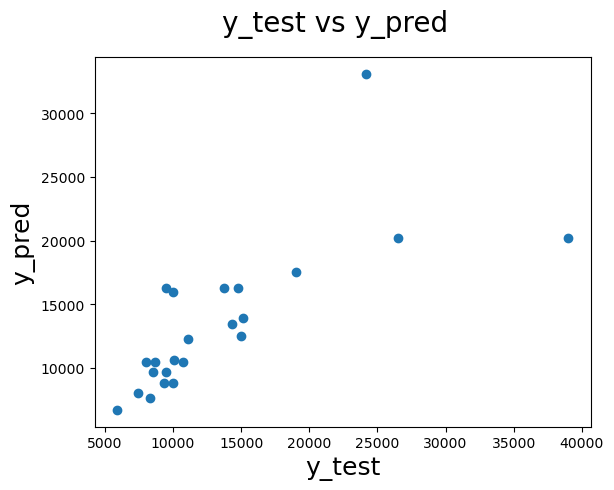

In [32]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5537979060628426
MAE : 3665.286549028318
MSE : 24601693.99373232
RMSE: 4960.009475165579


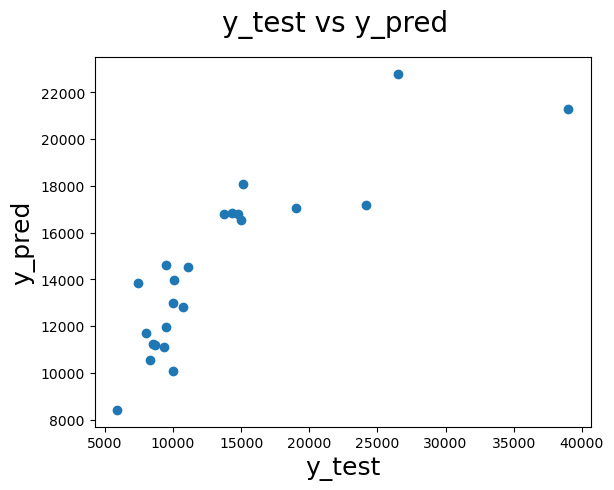

In [33]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.6759877514438366
MAE : 2716.8194659559254
MSE : 17864663.338676598
RMSE: 4226.661015349658


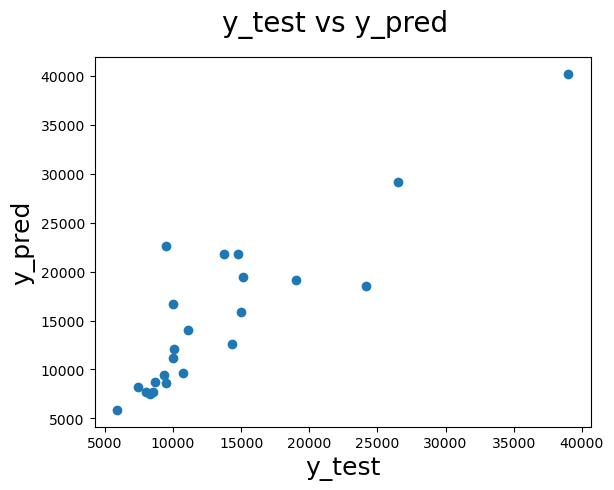

In [34]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7055509721579176
MAE : 2807.2539989922398
MSE : 16234672.53549713
RMSE: 4029.227287644261


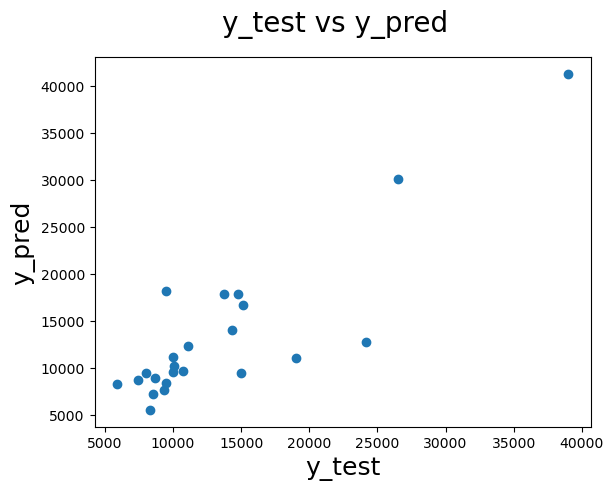

In [35]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7191313776303144
MAE : 2740.8747014482897
MSE : 15485906.484682117
RMSE: 3935.2136517198296


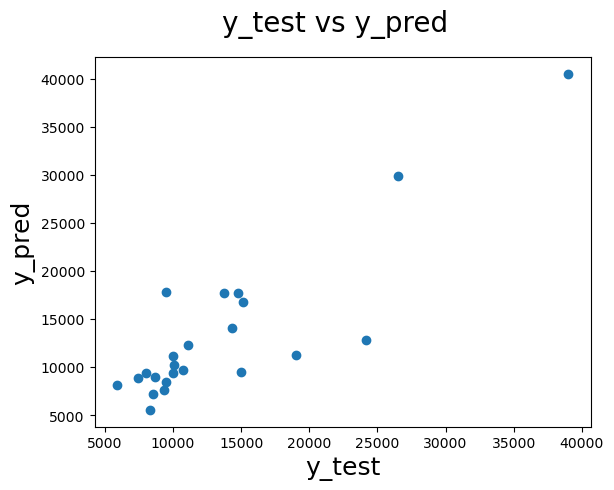

In [36]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7094421430330335
MAE : 2771.8891286439643
MSE : 16020129.850808593
RMSE: 4002.51544042101


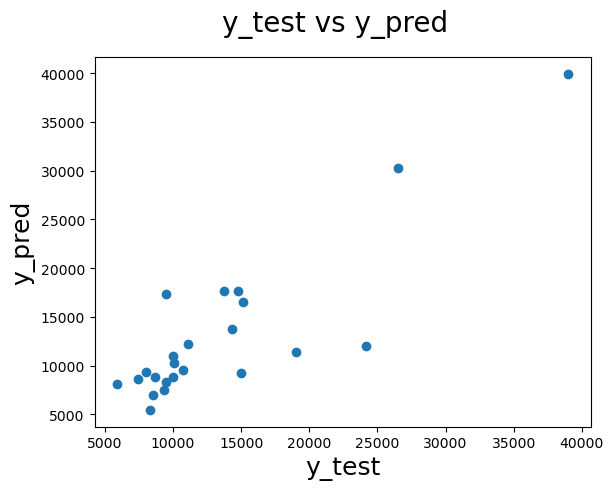

In [37]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.024198484765411976
MAE : 5031.164909450682
MSE : 56469967.428238235
RMSE: 7514.6501866845565


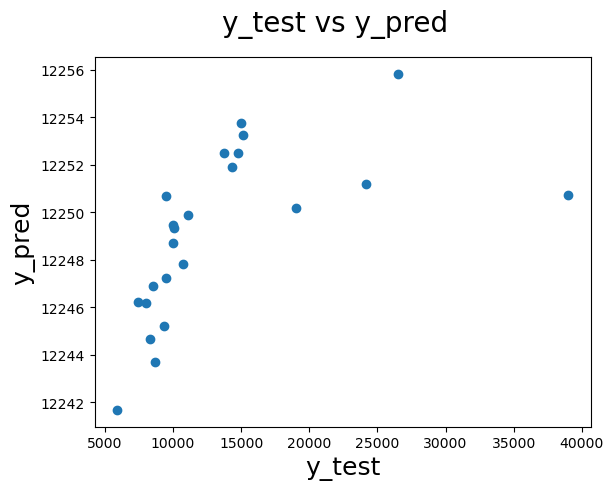

In [38]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7181372859483042
MAE : 2390.851701047744
MSE : 15540716.490495259
RMSE: 3942.1715450364736


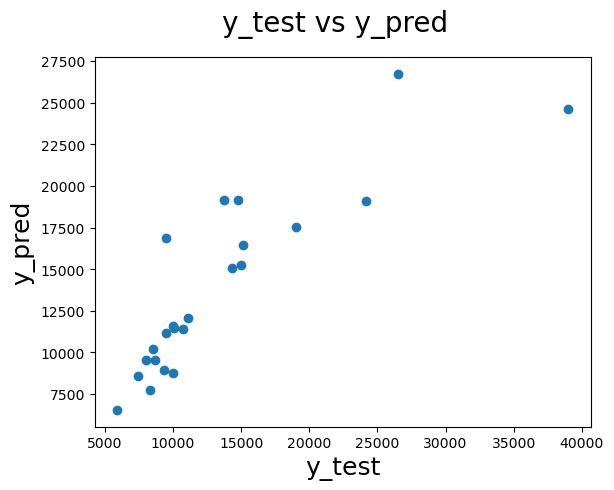

In [39]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance for Feature Engineering

## Chi-squared (χ²) test

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(25,'Score'))  

                           Specs         Score
0                       tdweight  14840.381067
2           Cabin exterior width    204.470333
1                         length    200.549106
7               Rear Door Window    178.000000
3                        eheight    121.154337
9                  Wall Material    118.896552
19                         STOVE    107.657895
8                      Rear Door     99.793103
4                        Windows     80.673307
15                      Cabinets     60.678899
11                           A/C     59.168831
16                  Refrigerator     57.925373
20                  USB Charging     54.826087
14          Battery Power Supply     47.278351
10  Usage Intent- On or Off Road     45.591837
18                         Solar     44.142857
6                   Door Windows     39.920455
13                    Spare Tire     29.168142
17                        Awning     22.593750
12                     Roof Rack     18.428571
5            

The *chi-squared (χ²) test* is a statistical hypothesis test used to determine the independence of two categorical variables. It is commonly used in machine learning to test the relationship between a feature and a target variable.

The chi-squared test is applicable only to non-negative features and is based on the assumption that the expected frequency of each category should be at least 5. If the expected frequency is less than 5, then the test result may not be reliable.

In the chi-squared test, the observed frequencies of each category are compared to the expected frequencies. The expected frequency of each category is calculated based on the null hypothesis of independence between the feature and the target variable. If the observed frequency significantly deviates from the expected frequency, then the null hypothesis is rejected, indicating that the feature is associated with the target variable.

The chi-squared test outputs a p-value, which represents the probability of observing the test results given that the null hypothesis is true. A small p-value indicates that the feature and target variable are likely associated, while a large p-value suggests that they are independent.

In general, a higher SelectKBest score indicates that the feature is more strongly associated with the target variable, and thus more relevant for the model. Conversely, a lower score indicates that the feature is less important for predicting the target variable.

## Extra Tree Classifier Top 10 Features 

[0.21500658 0.13709785 0.1142595  0.10902991 0.03508966 0.03147202
 0.03045499 0.00256757 0.0210592  0.02040439 0.04163789 0.02261011
 0.02546879 0.02525041 0.02527231 0.0295223  0.02412257 0.02584764
 0.02293188 0.02220567 0.01868877]


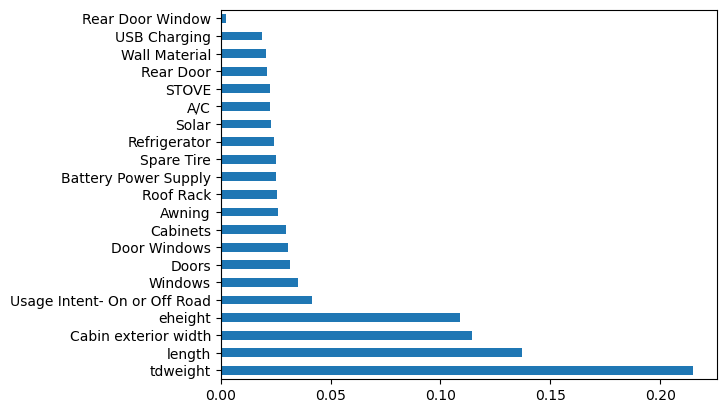

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

To obtain the feature importance of a dataset, one can utilize the feature importance property of the model being used. This property generates a score for each feature, with a higher score indicating greater importance or relevance to the output variable.

The feature importance function is a pre-existing class that is available in Tree-Based Classifiers. In this instance, we will utilize the Extra Tree Classifier to identify the top features of the dataset.

We can see weight is still the most highly correlated to price, followed by other dimensions, On/Off Road and doors/windows. These features are vasty different from the features indicated to be most highly correlated with the price (heatmap).

## Correlation  

In [42]:
#these features have the highest correlation with price
top_corr = data2
corr_matrix = top_corr.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                           1.000000
tdweight                        0.832351
Cabinets                        0.639483
STOVE                           0.524088
Battery Power Supply            0.505242
length                          0.397530
Refrigerator                    0.328696
Solar                           0.327537
eheight                         0.314120
USB Charging                    0.289376
Spare Tire                      0.281029
Wall Material                   0.280721
Door Windows                    0.266848
A/C                             0.213569
Cabin exterior width            0.157548
Doors                           0.122581
Roof Rack                       0.061454
Awning                         -0.057099
Rear Door Window               -0.059333
Rear Door                      -0.068498
Windows                        -0.165411
Usage Intent- On or Off Road   -0.185195
Name: price, dtype: float64


# Regressive Feature Selection
Recursive feature elimination is an example of backward feature elimination in which we essentially first fit our model using all the features in a given set, then progressively one by one we remove the least significant features, each time re-fitting, until we are left with the desired number of features, which is set by the parameter n_features_to_select

In [43]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

# perform a scikit-learn Recursive Feature Elimination (RFE)

#we want only one final feature to produce a ranking
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# print out features in order of ranking
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

# choose top 10 featues and use them for the model
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# use the model to predict the prices for the test data
predictions = rfe.predict(X_test)

1 tdweight
2 Cabinets
3 eheight
4 STOVE
5 Windows
6 Wall Material
7 USB Charging
8 A/C
9 Cabin exterior width
10 length
11 Doors
12 Spare Tire
13 Roof Rack
14 Solar
15 Refrigerator
16 Battery Power Supply
17 Door Windows
18 Awning
19 Usage Intent- On or Off Road
20 Rear Door
21 Rear Door Window


# Feature Engineering
This section is in progress while more feature data is collected.

In [44]:
#the last columns contain values we want to predict
data3=data.drop(data.index[90:])

In [45]:
#removing features which preformed worst in numerous tests 
X = data3.drop(['price', 'Wall Material', 'Rear Door', 'Rear Door Window'],axis=1)
y=data3['price']

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [47]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

R^2 :  0.6883041654194173
MAE : 3188.3175873410714
MSE : 17185588.426558327
RMSE: 4145.550437102211


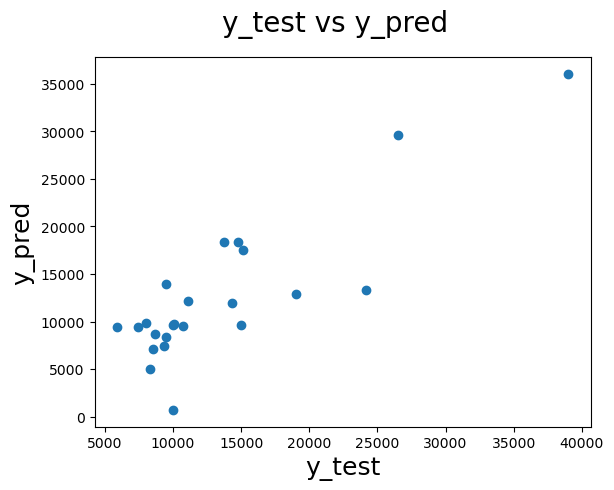

In [49]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.516919734387216
MAE : 2882.5652173913045
MSE : 26635000.217391305
RMSE: 5160.910793395998


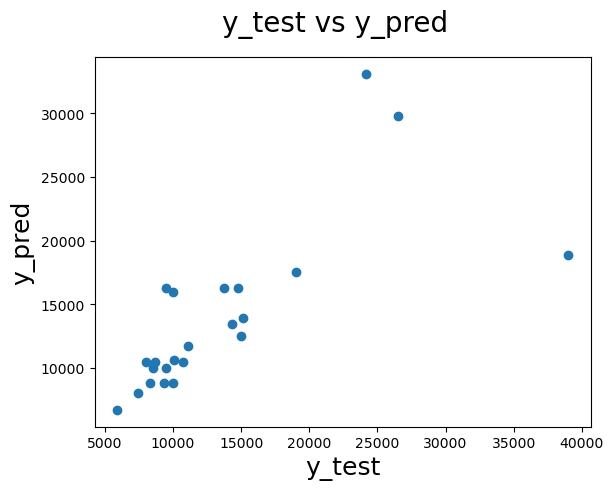

In [50]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.47759236453273535
MAE : 4078.351783460627
MSE : 28803344.85737529
RMSE: 5366.874775637614


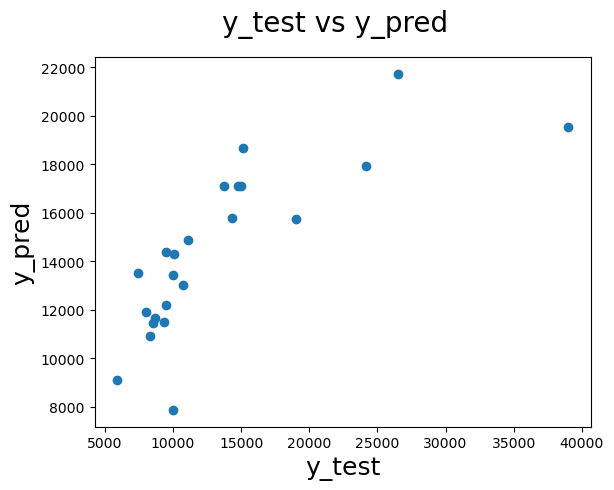

In [51]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7015086789789753
MAE : 2990.050229780434
MSE : 16457547.464083407
RMSE: 4056.7902908683122


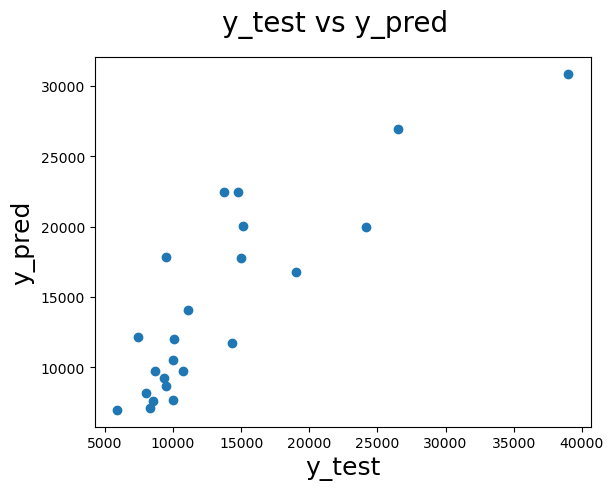

In [52]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7053000850023488
MAE : 3117.1926872348886
MSE : 16248505.390860496
RMSE: 4030.943486438441


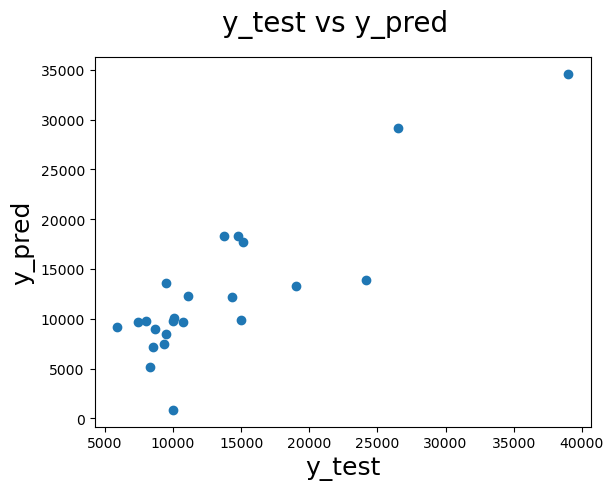

In [53]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7089328828817874
MAE : 3099.098598874054
MSE : 16048208.299059723
RMSE: 4006.0215050670563


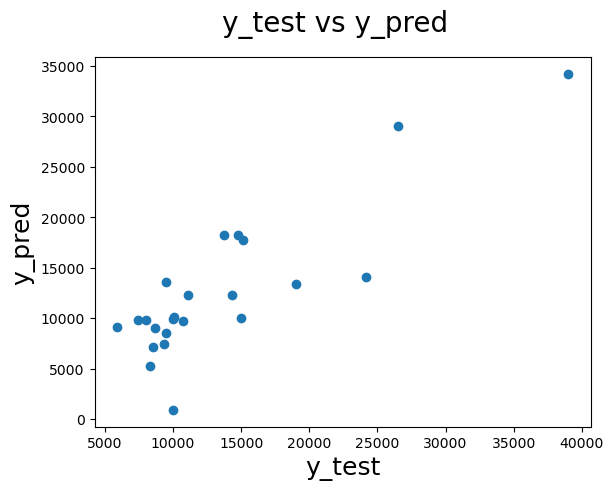

In [54]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.705041294790523
MAE : 3130.7152152403664
MSE : 16262773.987279959
RMSE: 4032.7129810191004


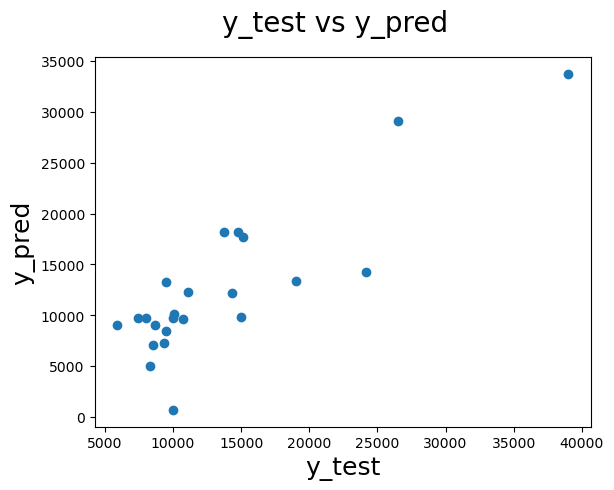

In [55]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.024163064398796674
MAE : 5030.9088713373585
MSE : 56468014.49921246
RMSE: 7514.520244114887


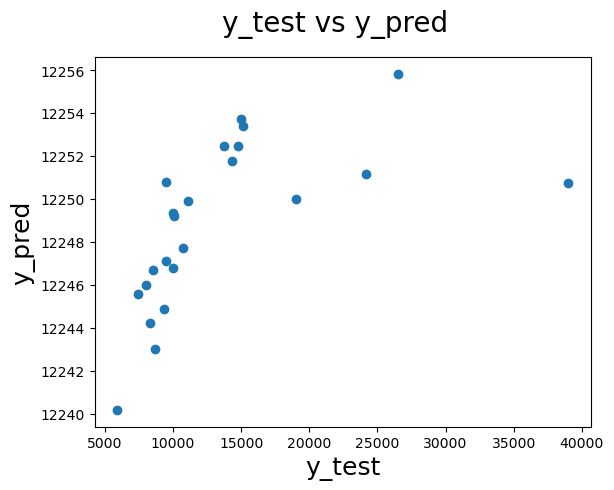

In [56]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.6796195961792053
MAE : 2511.0238133509006
MSE : 17664418.7992037
RMSE: 4202.90599457134


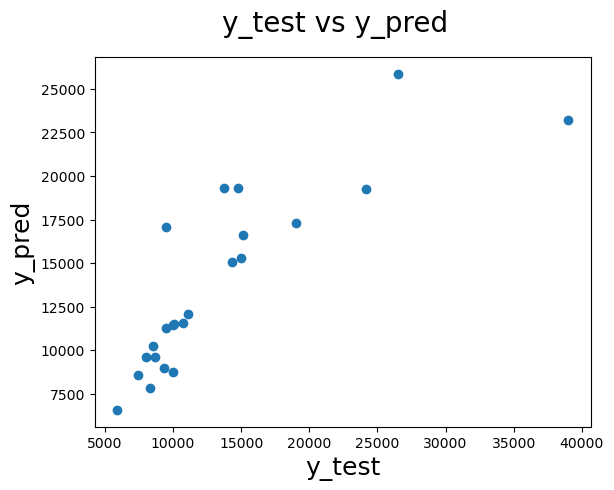

In [57]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.21362376 0.1505487  0.12074095 0.11686911 0.03562836 0.03217845
 0.0320075  0.0416755  0.02639909 0.02955879 0.02871666 0.0259589
 0.02720273 0.02914628 0.02966138 0.02248182 0.0203103  0.01729173]


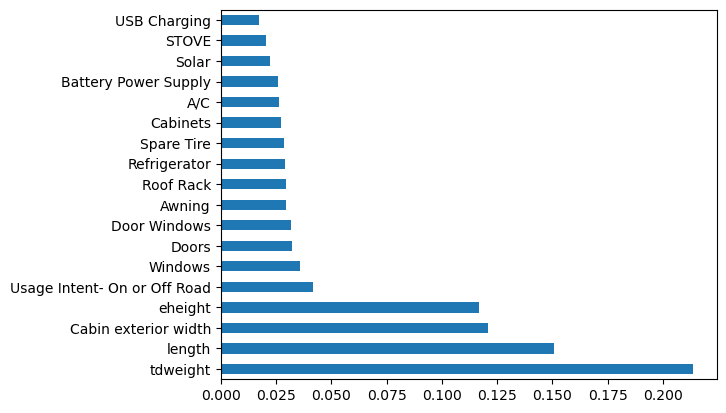

In [58]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [59]:
rfc=RandomForestRegressor(random_state=0)

In [60]:
param_grid = { 
    'n_estimators': [100, 500, 1000],
   # 'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    'max_depth' : [5, 10, 15],
    'min_samples_leaf' : [1,2,3],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [61]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 500, 1000]})

In [62]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 1000}

R^2 :  0.6290042974858885
MAE : 2570.5354699792956
MSE : 20455132.036039647
RMSE: 4522.73501722571


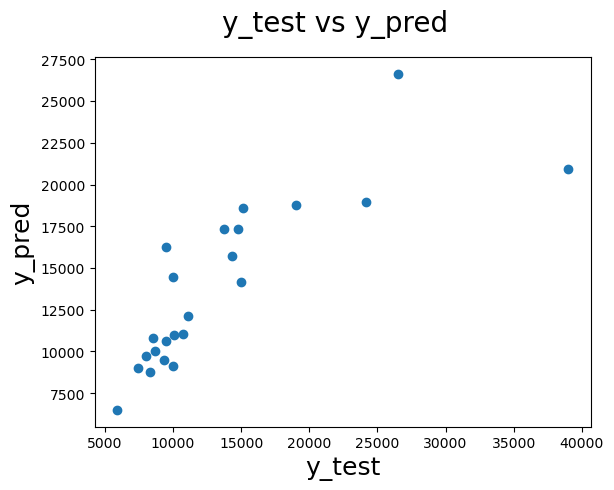

In [63]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=1000, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=0)
run_experiment(final_model)

# Checking the value of interest

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [65]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

R^2 :  0.38240052124019364
MAE : 2219.7663333333344
MSE : 10452165.484141314
RMSE: 3232.9808975837323


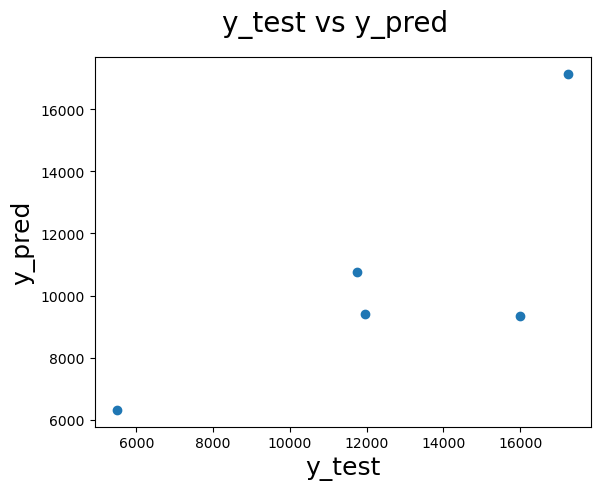

In [66]:
model_10 = RandomForestRegressor(n_estimators=1000, max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(model_10)

In [67]:
new_input = data.loc[90:]
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
90,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,0,0,0,0,0,0,0,0,9995
91,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,0,0,0,0,0,0,0,2,9995
92,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,0,0,0,0,0,0,2,2,9995
93,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,0,0,0,0,0,0,2,2,9995
94,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,0,0,0,0,0,2,2,2,9995
95,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,2,0,0,0,0,0,0,0,9995
96,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,2,0,0,0,0,0,0,2,9995
97,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,2,0,0,0,0,0,2,2,9995
98,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,2,0,0,0,0,0,2,2,9995
99,850,144.0,93.0,72.0,4,2,2,2,3,3,...,2,2,0,0,0,0,2,2,2,9995


In [68]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Wall Material', 'Rear Door', 'Rear Door Window'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
90,850,144.0,93.0,72.0,4,2,2,2,2,2,0,0,0,0,0,0,0,0
91,850,144.0,93.0,72.0,4,2,2,2,2,2,0,0,0,0,0,0,0,2
92,850,144.0,93.0,72.0,4,2,2,2,2,2,0,0,0,0,0,0,2,2
93,850,144.0,93.0,72.0,4,2,2,2,2,2,0,0,0,0,0,0,2,2
94,850,144.0,93.0,72.0,4,2,2,2,2,2,0,0,0,0,0,2,2,2
95,850,144.0,93.0,72.0,4,2,2,2,2,2,2,0,0,0,0,0,0,0
96,850,144.0,93.0,72.0,4,2,2,2,2,2,2,0,0,0,0,0,0,2
97,850,144.0,93.0,72.0,4,2,2,2,2,2,2,0,0,0,0,0,2,2
98,850,144.0,93.0,72.0,4,2,2,2,2,2,2,0,0,0,0,0,2,2
99,850,144.0,93.0,72.0,4,2,2,2,2,2,2,0,0,0,0,2,2,2


In [69]:
new_input_scaled = scaler.fit_transform(new_input)

In [70]:
new_output = model_10.predict(new_input_scaled)
new_output

array([10717.21      , 10461.07633333, 10694.93058333, 10694.93058333,
       10916.47158333, 10619.53      , 10402.18733333, 10632.43158333,
       10632.43158333, 10843.88375   , 10622.12      , 10382.804     ,
       10596.26575   , 10596.26575   , 10802.51475   , 10530.762     ,
       10325.345     , 10538.80675   , 10538.80675   , 10734.96691667])

###### <iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>

# Runaway Test

Individual values of interest are checked using the final model 

In [71]:
#drop the actual test values, plus the values from this brand to exclude from the test set
#data4=data3.drop(data.index[20:24])

In [72]:
#removing features which preformed worst in numerous tests 
#X = data4.drop(['price'],axis=1)
#y=data4['price']

In [73]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [74]:
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [75]:
#def runaway_experiment(model):
#    model.fit(X_train_scaled, y_train)
#    y_pred = model.predict(X_test_scaled)
#    print("R^2 : ", r2_score(y_test, y_pred))
#    print("MAE :", mean_absolute_error(y_test,y_pred))
#    print("MSE :", mean_squared_error(y_test,y_pred))
#    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
#    fig = plt.figure()
#    plt.scatter(y_test,y_pred)
#    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
#    plt.xlabel('y_test', fontsize=18)                          # X-label
#    plt.ylabel('y_pred', fontsize=18) 


In [76]:
#model_10 = RandomForestRegressor(n_estimators=500, max_features='auto', max_depth=5, min_samples_leaf=1, random_state=32)
#(criterion= 'squared_error', n_estimators=1000, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=0)
#(n_estimators=5000, max_depth=15, min_samples_leaf=3, random_state=1)
#runaway_experiment(model_10)

In [77]:
#runaway = data.loc[20:24]
#runaway

In [78]:
#drop the variable to be predicted
#runaway_new=runaway.drop(['price'],axis=1)
#, 'Wall Material', 'Rear Door', 'Rear Door Window'
#runaway_new

In [79]:
#runaway_scaled = scaler.fit_transform(runaway_new)

In [80]:
#rouser = runaway_new.loc[24:24]
#rouser

In [81]:
#rouser_scaled = scaler.fit_transform(rouser)

In [82]:
#rangerunner = runaway_new.loc[21:21]

In [83]:
#rangerunner_scaled = scaler.fit_transform(rangerunner)

In [84]:
#rouser_test = model_10.predict(rouser_scaled)
#rouser_test

In [85]:
#rangerunner_test = model_10.predict(rangerunner_scaled)
#rangerunner_test

In [86]:
#runaway_test = model_10.predict(runaway_scaled)
#runaway_test

5995, 7645, 9650, 11945, 9220